In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


Установка yolov5 и зависимостей

In [ ]:
!git clone https://github.com/ultralytics/yolov5
%pip install -qr yolov5/requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 16057, done.
remote: Total 16057 (delta 0), reused 0 (delta 0), pack-reused 16057
Receiving objects: 100% (16057/16057), 14.66 MiB | 18.26 MiB/s, done.
Resolving deltas: 100% (11028/11028), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.2/645.2 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have pillow 10.1.0 which is incompatible.


Включаем корректное отображение графиков

In [ ]:
%matplotlib notebook
%matplotlib inline

Установка и импорт зависимостей

In [ ]:
from glob import glob
import torch
import cv2
from sklearn.metrics import mean_squared_error as mse
from PIL import Image
import random
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

Загрузка датасета

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="lp2eM57Wj86jDYCtWMPq")
project = rf.workspace("weapondetector-bjvfe").project("weapon_detector")
dataset = project.version(10).download("yolov5")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninstalled opencv-python-headless-4.8.1.78
  Attempting uninstall: idna
    Found existing 

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to weapon_detector-10 in yolov5pytorch:: 100%|██████████| 3912/3912 [00:00<00:00, 5573.54it/s]


Исследование данных

In [ ]:
!mv weapon_detector-10 data
!ls
!ls data

data  gdrive  sample_data  yolov5
data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


In [ ]:
from glob import glob


pathes = glob('data/train/labels/*')
nums = []
size_width = []
size_height = []

print(pathes)

for pth in pathes:
    with open(pth, 'r') as f:
        nums.append(0)
        for line in f:
            nums[-1] += 1
            width, height = map(float, line.split(' ')[-2:])
            size_width.append(width*640)
            size_height.append(height*640)

print(f'Среднее количество оружия или стрелков на фото: {sum(nums)/len(nums):.2f}')
print(f'Средний размер оружия: {sum(size_width)/len(size_width):.2f}x{sum(size_height)/len(size_height):.2f}')
print(f'Максимальная высота {max(size_height)}, ширина - {max(size_width)}')
print(f'Минимальная высота {min(size_height)}, ширина - {min(size_width)}')

['data/train/labels/youtube-25_jpg.rf.95a826cd986ceed8051ccf88b92f9dde.txt', 'data/train/labels/youtube-156_jpg.rf.be96be7e36dd61c8d3ff93f21164236a.txt', 'data/train/labels/youtube-315_jpg.rf.fd6c886e116c6759b25edf49e656ca95.txt', 'data/train/labels/youtube-327_jpg.rf.554af96a3ba72b89b8ed5597d8bcd28b.txt', 'data/train/labels/youtube-111_jpg.rf.18a85042e5d8b661aef5fbc865471fb9.txt', 'data/train/labels/youtube-291_jpg.rf.1b0c6c9d0949034c622019df0375e089.txt', 'data/train/labels/youtube-479_jpg.rf.9ddc9d29bcd4423761c0c24662d91661.txt', 'data/train/labels/youtube-437_jpg.rf.1ba024eab3bb66eb147e5aebda69fa6f.txt', 'data/train/labels/youtube-515_jpg.rf.e38c4990a296c56e89dcb8c147bef3c1.txt', 'data/train/labels/weapon-4-5m0s-_mp4-170_jpg.rf.5424538e73267ba75819624eef851408.txt', 'data/train/labels/weapon-2-cropped_mp4-216_jpg.rf.9386e6000206a527d82b1e6e99cb2ee9.txt', 'data/train/labels/no_weapon7_mp4-38_jpg.rf.86168bf93e2f8c10eb0ec03c199444af.txt', 'data/train/labels/weapon-1-5m0s-_mp4-177_jpg.

Построим тепловую карту того, где чаще всего бывает оружие

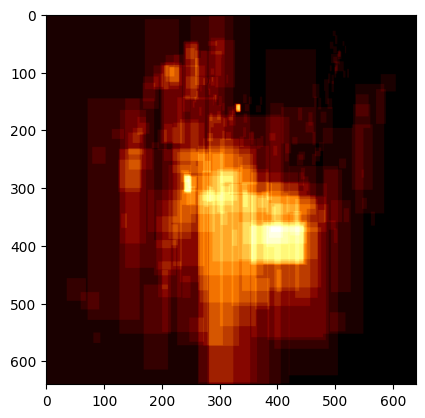

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


heatmap = np.zeros((640, 640))
width = 640
height = 640
for pth in pathes:
    with open(pth, 'r') as f:
        for line in f:
            x, y, w, h = map(float, line.split(' ')[-4:])
            x_center = int(x * width)
            y_center = int(y * height)
            w = int(w * width)
            h = int(h * height)
            x1 = int(x_center - w / 2)
            y1 = int(y_center - h / 2)
            x2 = x1 + w
            y2 = y1 + h
            heatmap[y1:y2, x1:x2] += 1

plt.imshow(heatmap, cmap='afmhot')
plt.show()

Выведем несколько фото

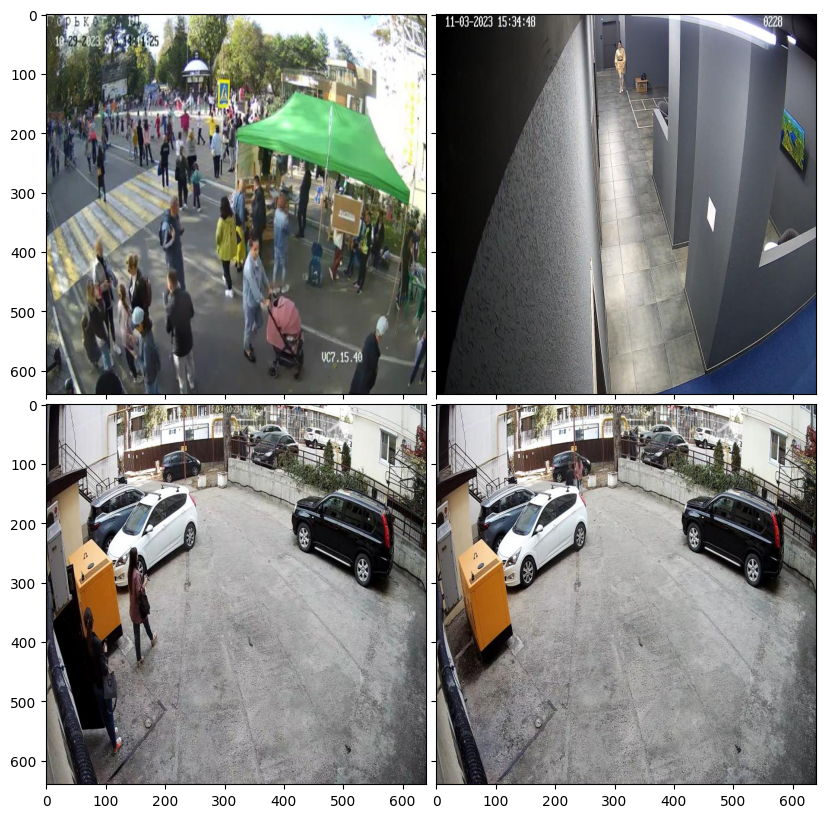

In [ ]:
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 2),
                 axes_pad=0.1,
                 )

pathes = glob(f'data/train/images/*') #пути ко всем файлам в папке
images = [cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in random.choices(pathes, k = 4)] #выбираем 4 случайных фото и переводим их в RGB (OpenCV хранит фото в цветовом окружение BGR)

for ax, im in zip(grid, images):
    ax.imshow(im)

plt.show()

Корректировка путей и классов для обучения

In [ ]:
data_yaml = """names:
- pistol
- rifle
- shooter
nc: 3
roboflow:
  license: MIT
  project: weapon_detector
  url: https://universe.roboflow.com/weapondetector-bjvfe/weapon_detector/dataset/10
  version: 10
  workspace: weapondetector-bjvfe
test: ../data/test/images
train: ../data/train/images
val: ../data/valid/images
"""

with open('data/data.yaml', 'w') as file:
    file.write(data_yaml)

Обучаем модель

In [ ]:
!python yolov5/train.py --img 640 --batch 24 --epochs 300 --data data/data.yaml --weights /content/gdrive/MyDrive/Runs/Run_11Nov23/weights/last.pt --cache ram --project "/content/gdrive/MyDrive/Runs"  --name Run_11Nov23_2 # --hyp yolov5/data/hyps/hyp.scratch-low.yaml

2023-11-11 13:42:04.946188: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-11 13:42:04.946255: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-11 13:42:04.946300: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=/content/gdrive/MyDrive/Runs/Run_11Nov23/weights/last.pt, cfg=, data=data/data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=300, batch_size=24, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=

В случае сбоя продолжаем обучение

In [ ]:
!python yolov5/train.py --resume /content/gdrive/MyDrive/Runs/Run_11Nov23_2/weights/last.pt

2023-11-11 15:47:58.801318: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-11 15:47:58.801387: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-11 15:47:58.801428: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5/yolov5s.pt, cfg=, data=yolov5/data/coco128.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=640, rect=False, resume=/content/gdrive/MyDrive/Runs/Run_11Nov23_2/weights/last.pt, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi

Предсказываем результат на тестовых данных

In [ ]:
!python yolov5/detect.py --weights /content/yolov5/runs/train/exp4/weights/best.pt --img 640 --conf 0.25 --source data/valid/images

detect: weights=['/content/yolov5/runs/train/exp4/weights/best.pt'], source=data/test/images, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.15, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-238-gd5d514e Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
image 1/33 /content/data/test/images/Disturbing-new-footage-shows-Salvador-Ramos-in-Uvalde-school-cops-running-New-York-Post_mp4-18_jpg.rf.e6b31b5a664237b30f2f0d5cdce5b176.jpg: 640x640 (no detections), 11.5ms
image 2/33 /content/data/test/images/Disturbing-new-footage-shows-Salvador-Ramos-in-Uvalde-sc

Визуализируем результат

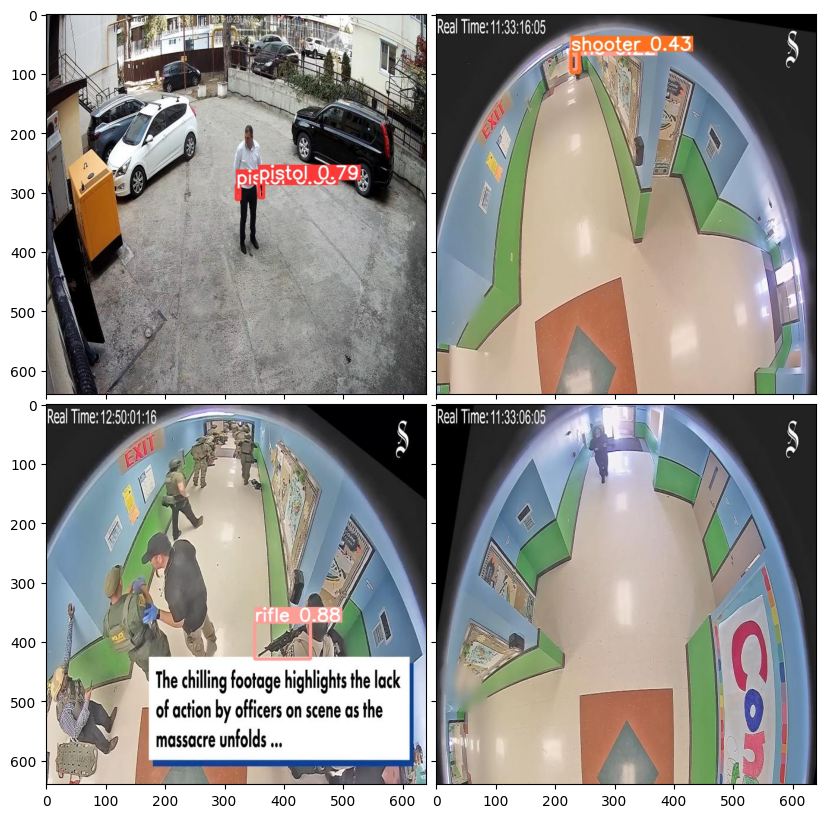

In [ ]:
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 2),
                 axes_pad=0.1,
                 )

pathes = glob('yolov5/runs/detect/exp3/*')
# print(pathes)
images = [cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in random.choices(pathes, k = 4)]

for ax, im in zip(grid, images):
    ax.imshow(im)

plt.show()